In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

register_matplotlib_converters()

In [6]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [36]:
url = "https://raw.githubusercontent.com/ritvikmath/Time-Series-Analysis/master/ice_cream.csv"

In [37]:
data = pd.read_csv(url, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
data.head()

DATE
1972-01-01    59.9622
1972-02-01    67.0605
1972-03-01    74.2350
1972-04-01    78.1120
1972-05-01    84.7636
Name: IPN31152N, dtype: float64

In [38]:
data = data.asfreq(pd.infer_freq(data.index))


In [45]:

start_date = datetime(2010,1,1)
revised_data = data[start_date:]

Text(0, 0.5, 'Production')

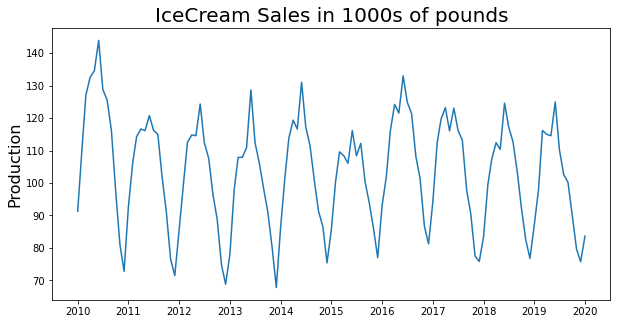

In [47]:
plt.figure(figsize=(10,5))
plt.plot(revised_data)
plt.title('IceCream Sales in 1000s of pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)

## ACF Plot

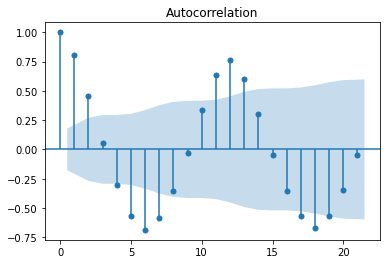

In [67]:
acf_plot = plot_acf(revised_data)

## PACF

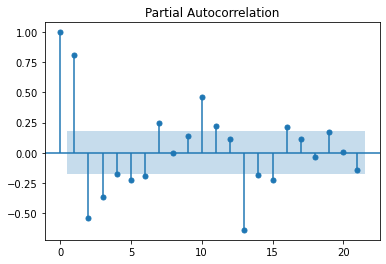

In [68]:
pacf_plot = plot_pacf(revised_data)

we can see here 1,2,3,8,12 have significant correlation. we will try to build Auto regression model using 3 lags  

## Training and testing set

In [69]:
train_end = datetime(2018,12,1)
test_end = datetime(2019,12,1)
train_data = revised_data[:train_end]
test_data = revised_data[train_end+timedelta(days=1):test_end]

In [70]:
train_data.head()

DATE
2010-01-01     91.2895
2010-02-01    110.4994
2010-03-01    127.0971
2010-04-01    132.6468
2010-05-01    134.5576
Freq: MS, Name: IPN31152N, dtype: float64

In [71]:
test_data.head()

DATE
2019-01-01     86.9988
2019-02-01     98.1116
2019-03-01    116.1718
2019-04-01    114.9703
2019-05-01    114.5613
Freq: MS, Name: IPN31152N, dtype: float64

## Fit AR Model

In [72]:
order = 3
model = ARMA(train_data,order=(order,0))

C:\Users\Omkar\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [73]:
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:              IPN31152N   No. Observations:                  108
Model:                     ARMA(3, 0)   Log Likelihood                -374.085
Method:                       css-mle   S.D. of innovations              7.642
Date:                Tue, 08 Jun 2021   AIC                            758.170
Time:                        07:30:55   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             103.5743      1.809     57.265      0.000     100.029     107.119
ar.L1.IPN31152N     1.0469      0.088     11.960      0.000       0.875       1.218
ar.L2.IPN31152N    -0.0523      

## Prediction

In [74]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
pred_start_date

Timestamp('2019-01-01 00:00:00', freq='MS')

In [75]:
pred_end_date

Timestamp('2019-12-01 00:00:00', freq='MS')

In [76]:
prediction = model_fit.predict(start=pred_start_date,end=pred_end_date)
residual = test_data - prediction

In [77]:
residual

DATE
2019-01-01     5.762492
2019-02-01     7.970969
2019-03-01    14.648439
2019-04-01     3.806039
2019-05-01    -2.499466
2019-06-01     6.834555
2019-07-01    -4.770270
2019-08-01    -6.746893
2019-09-01    -2.967785
2019-10-01    -8.016208
2019-11-01   -15.893934
2019-12-01   -19.990279
Freq: MS, dtype: float64

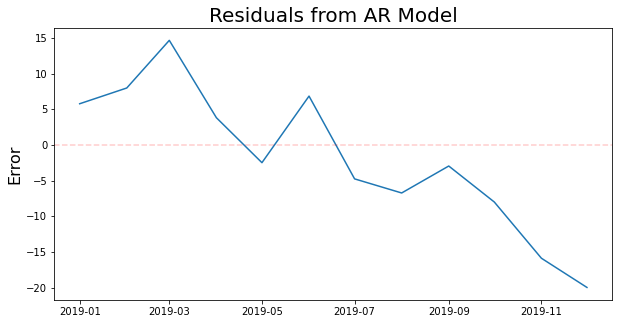

In [78]:
plt.figure(figsize=(10,5))
plt.plot(residual)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

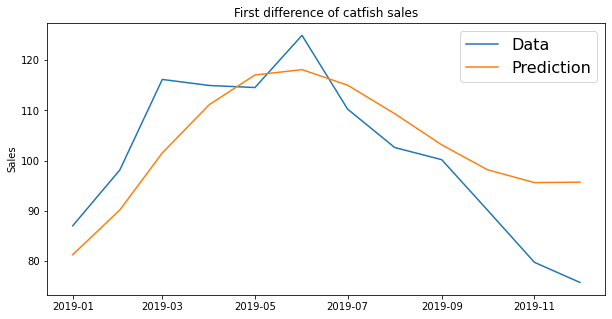

In [79]:
plt.figure(figsize=(10,5))
plt.plot(test_data)
plt.plot(prediction)
plt.legend(('Data','Prediction'),fontsize=16)
plt.title("First difference of catfish sales")
plt.ylabel("Sales")


In [80]:
print("RMSE",np.sqrt(np.mean(residual**2)))

RMSE 9.88405943870512


## Rolling Window

We will use rolling window to see whether it gives better results or not 
#### Tradeoff - we need to fit model for every month in test set

In [85]:
prediction_list = pd.Series()
for end_date in test_data.index:
    train_data = revised_data[:end_date-timedelta(days=1)]
    model = ARMA(train_data,order=(3,0))
    model_fit = model.fit()
    prediction = model_fit.predict(end_date)
    prediction_list.loc[end_date] = prediction.loc[end_date]

<ipython-input-85-4e249d6c33bc>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prediction_list = pd.Series()


In [86]:
rolling_residual = test_data - prediction_list
rolling_residual

DATE
2019-01-01     5.762492
2019-02-01     1.795700
2019-03-01     6.476774
2019-04-01    -8.991559
2019-05-01    -2.493582
2019-06-01    15.656323
2019-07-01   -10.613108
2019-08-01    -2.608316
2019-09-01     6.459123
2019-10-01    -7.445733
2019-11-01   -10.664553
2019-12-01    -5.157900
Freq: MS, dtype: float64

Text(0.5, 1.0, 'Rolling residual')

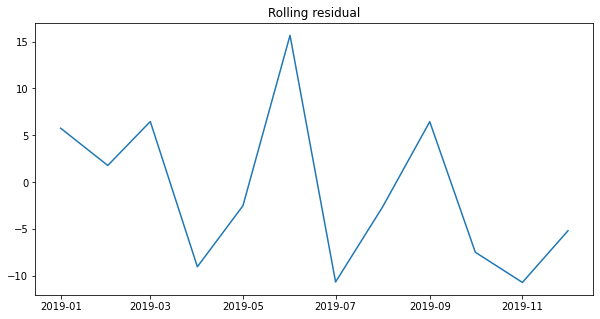

In [87]:
plt.figure(figsize=(10,5))
plt.plot(rolling_residual)
plt.title("Rolling residual")

Text(0, 0.5, 'Sales')

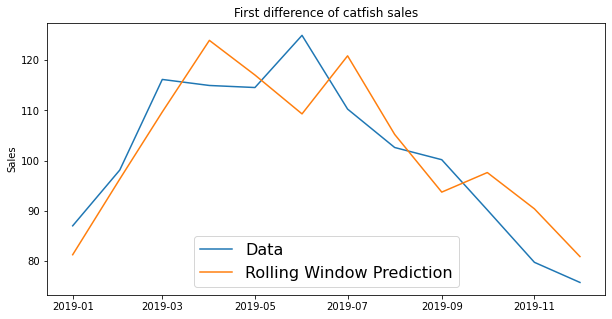

In [88]:
plt.figure(figsize=(10,5))
plt.plot(test_data)
plt.plot(prediction_list)
plt.legend(('Data','Rolling Window Prediction'),fontsize=16)
plt.title("First difference of catfish sales")
plt.ylabel("Sales")
